In [1]:
import os
import cartopy.crs as ccrs
import easygems.healpix as egh
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import intake
import colormaps as cmaps
from colormaps.utils import concat
from matplotlib.colors import ListedColormap
mpl.rcParams['figure.dpi'] = 72

# Testing HEALPix IMERG Data with Temporal Coarsening

This notebook tests reading and visualizing HEALPix IMERG data, including temporally coarsened data to verify that time coordinates are correctly aligned to window start times.

In [2]:
in_dir = '/pscratch/sd/w/wcmca1/GPM/healpix/'
# in_file = f'{in_dir}IMERG_V7_1H_zoom9_20190101_20211231.zarr'
# in_file = f'{in_dir}IMERG_V7_1H_zoom8_20190101_20211231.zarr'
# in_file = f'{in_dir}IMERG_V7_6H_zoom8_20200801_20200831.zarr'
in_file = f'{in_dir}IMERG_V7_6H_zoom6_20190101_20211231.zarr'
print(f"{in_file} exists: {os.path.exists(in_file)}")

# # Also check if zoom 8 exists for comparison
# zoom8_file = f'{in_dir}IMERG_V7_1H_zoom8_20200101_20200105.zarr'
# print(f"Zoom 8 file exists: {os.path.exists(zoom8_file)}")

/pscratch/sd/w/wcmca1/GPM/healpix/IMERG_V7_6H_zoom6_20190101_20211231.zarr exists: True


In [3]:
# Read data
ds = xr.open_zarr(in_file)
ds = ds.pipe(egh.attach_coords)
ds 

<xarray.Dataset> Size: 863MB
Dimensions:        (time: 4384, cell: 49152)
Coordinates:
  * time           (time) datetime64[ns] 35kB 2019-01-01 ... 2021-12-31T18:00:00
    crs            int64 8B 0
  * cell           (cell) int32 197kB 0 1 2 3 4 ... 49148 49149 49150 49151
    lat            (cell) float64 393kB 89.27 89.27 89.27 ... -89.27 -89.27
    lon            (cell) float64 393kB 45.0 135.0 225.0 ... 135.0 225.0 315.0
Data variables:
    precipitation  (time, cell) float32 862MB dask.array<chunksize=(24, 49152), meta=np.ndarray>
Attributes: (12/13)
    coarsened_from_zoom:         7
    coarsening_factor:           4
    coarsening_method:           mean
    grid_mapping:                crs
    healpix_nest:                True
    healpix_npix:                3145728
    ...                          ...
    healpix_order:               9
    original_grid:               regular_lat_lon
    processing_timestamp:        2025-08-07T16:29:54.689855
    remapping_method:            delaunay_triangulation
    source_file:                 IMERG_V7_1H_zoom9_20190101_20211231.zarr
    temporal_coarsening_factor:  6

In [4]:
ds.time.isel(time=slice(0, 24))

<xarray.DataArray 'time' (time: 24)> Size: 192B
array(['2019-01-01T00:00:00.000000000', '2019-01-01T06:00:00.000000000',
       '2019-01-01T12:00:00.000000000', '2019-01-01T18:00:00.000000000',
       '2019-01-02T00:00:00.000000000', '2019-01-02T06:00:00.000000000',
       '2019-01-02T12:00:00.000000000', '2019-01-02T18:00:00.000000000',
       '2019-01-03T00:00:00.000000000', '2019-01-03T06:00:00.000000000',
       '2019-01-03T12:00:00.000000000', '2019-01-03T18:00:00.000000000',
       '2019-01-04T00:00:00.000000000', '2019-01-04T06:00:00.000000000',
       '2019-01-04T12:00:00.000000000', '2019-01-04T18:00:00.000000000',
       '2019-01-05T00:00:00.000000000', '2019-01-05T06:00:00.000000000',
       '2019-01-05T12:00:00.000000000', '2019-01-05T18:00:00.000000000',
       '2019-01-06T00:00:00.000000000', '2019-01-06T06:00:00.000000000',
       '2019-01-06T12:00:00.000000000', '2019-01-06T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 192B 2019-01-01 ... 2019-01-06T18:00:00
    crs      int64 8B 0

In [5]:
# ds.time.dt.strftime('%Y')
ds.time.isel(time=0).dt.strftime('%Y-%m-%d %H:%M').item()

'2019-01-01 00:00'

<Figure size 460.8x345.6 with 0 Axes>

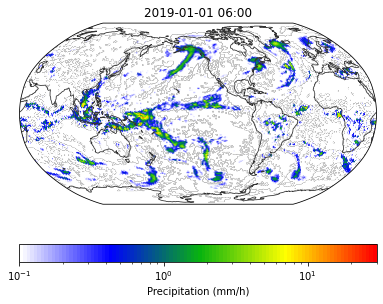

In [6]:
itime = 1
im = egh.healpix_show(ds.precipitation.isel(time=itime),norm=mpl.colors.LogNorm(vmin=10e-2, vmax=30), cmap=cmaps.WhBlGrYeRe)
time_str = ds.time.isel(time=itime).dt.strftime('%Y-%m-%d %H:%M').item()
plt.title(time_str)
plt.colorbar(im, orientation='horizontal', label='Precipitation (mm/h)')

<Figure size 460.8x345.6 with 0 Axes>

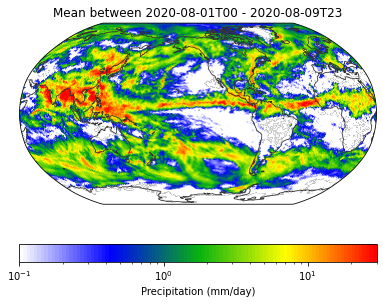

In [7]:
# time_str1 = '2019-06-01T00'
# time_str2 = '2019-08-31T23'
time_str1 = '2020-08-01T00'
time_str2 = '2020-08-09T23'
pcp_avg = ds.precipitation.sel(time=slice(time_str1, time_str2)).mean(dim='time') * 24
im = egh.healpix_show(pcp_avg,norm=mpl.colors.LogNorm(vmin=10e-2, vmax=30), cmap=cmaps.WhBlGrYeRe)
plt.title(f'Mean between {time_str1} - {time_str2}')
plt.colorbar(im, orientation='horizontal', label='Precipitation (mm/day)')

<Figure size 460.8x345.6 with 0 Axes>

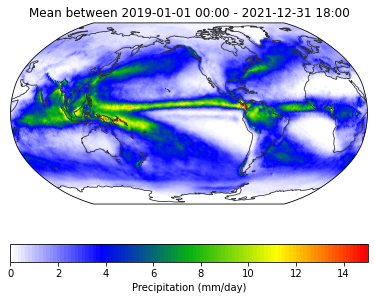

In [ ]:
pcp_avg = ds.precipitation.mean(dim='time') * 24
im = egh.healpix_show(pcp_avg,norm=mpl.colors.Normalize(vmin=0, vmax=15), cmap=cmaps.WhBlGrYeRe)
time_str1 = ds.time.min().dt.strftime('%Y-%m-%d %H:%M').item()
time_str2 = ds.time.max().dt.strftime('%Y-%m-%d %H:%M').item()
plt.title(f'Mean between {time_str1} - {time_str2}')
plt.colorbar(im, orientation='horizontal', label='Precipitation (mm/day)')